# 연습문제: 로그 데이터 분석

다음 데이터는 깃허브 서비스에서 요일 별 사용자들의 푸시 횟수로, 요일별로 푸시 횟수가 다르다고 한다. 분산분석을 수행하여 검증하시오.

- 데이터파일 : log_push.csv

### 필요 모듈 임포트

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%precision 4
plt.rcParams['font.family'] = 'AppleGothic'

#### 분산분석을 위한 모듈들 임포트

In [2]:
import statsmodels
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin
from pingouin import welch_anova, read_dataset

### 데이터 수집

In [3]:
df = pd.read_csv('data/log_push.csv')
df

,log_date,push_count
0,19-02-01,736729
1,19-02-02,511067
2,19-02-03,528724
3,19-02-04,709256
4,19-02-05,740087
...,...,...
343,20-01-10,1000151
344,20-01-11,729593
345,20-01-12,748161
346,20-01-13,1034195


### 데이터 기초 정보 파악

: 데이터 일부, 변수, 관측값수, 결측치 여부, 변수의 데이터타입, 기술통계량 등을 확인

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   log_date    348 non-null    object
 1   push_count  348 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.6+ KB


In [5]:
df.describe()

,push_count
count,3.480000e+02
mean,8.725456e+05
std,1.522160e+05
min,2.861550e+05
25%,7.229318e+05
50%,9.278870e+05
75%,9.864538e+05
max,1.135921e+06


### 데이터 가공

#### log_date컬럼을 이용하여 요일 컬럼(day_of_week) 생성

- log_date를 날짜형식으로 변경

In [6]:
df.log_date = '20' + df.log_date
df.log_date

0      2019-02-01
1      2019-02-02
2      2019-02-03
3      2019-02-04
4      2019-02-05
          ...    
343    2020-01-10
344    2020-01-11
345    2020-01-12
346    2020-01-13
347    2020-01-14
Name: log_date, Length: 348, dtype: object

In [7]:
df['log_date'] = pd.to_datetime(df['log_date'])
df

,log_date,push_count
0,2019-02-01,736729
1,2019-02-02,511067
2,2019-02-03,528724
3,2019-02-04,709256
4,2019-02-05,740087
...,...,...
343,2020-01-10,1000151
344,2020-01-11,729593
345,2020-01-12,748161
346,2020-01-13,1034195


- log_date를 이용하여 요일 컬럼(day_of_week) 생성

In [8]:
df['day_of_week'] = df['log_date'].dt.day_name()
df

,log_date,push_count,day_of_week
0,2019-02-01,736729,Friday
1,2019-02-02,511067,Saturday
2,2019-02-03,528724,Sunday
3,2019-02-04,709256,Monday
4,2019-02-05,740087,Tuesday
...,...,...,...
343,2020-01-10,1000151,Friday
344,2020-01-11,729593,Saturday
345,2020-01-12,748161,Sunday
346,2020-01-13,1034195,Monday


- 요일 컬럼의 데이터를 범주형(Category)으로 변경 

In [9]:
df['day_of_week'].astype('category')
df

,log_date,push_count,day_of_week
0,2019-02-01,736729,Friday
1,2019-02-02,511067,Saturday
2,2019-02-03,528724,Sunday
3,2019-02-04,709256,Monday
4,2019-02-05,740087,Tuesday
...,...,...,...
343,2020-01-10,1000151,Friday
344,2020-01-11,729593,Saturday
345,2020-01-12,748161,Sunday
346,2020-01-13,1034195,Monday


### 데이터 탐색 및 시각화

#### 요일별 빈도수

In [10]:
df.day_of_week.value_counts()

day_of_week
Friday       50
Saturday     50
Sunday       50
Monday       50
Tuesday      50
Wednesday    49
Thursday     49
Name: count, dtype: int64

In [11]:
df.groupby(by='day_of_week').describe()['log_date']['count']

day_of_week
Friday       50
Monday       50
Saturday     50
Sunday       50
Thursday     49
Tuesday      50
Wednesday    49
Name: count, dtype: object

In [12]:
df.groupby(by='day_of_week').describe()['log_date']['count'].to_dict()

{'Friday': 50,
 'Monday': 50,
 'Saturday': 50,
 'Sunday': 50,
 'Thursday': 49,
 'Tuesday': 50,
 'Wednesday': 49}

#### 요일별 push수에 대한 기술통계량

In [13]:
df1 = df.groupby(by='day_of_week').describe()['push_count']
df1

,count,mean,min,25%,50%,75%,max,std
day_of_week,,,,,,,,
Friday,50.0,897827.440000,660287.0,872606.25,906519.5,928941.00,1022900.0,68275.935770
Monday,50.0,955284.360000,709256.0,921506.75,954091.0,1004844.25,1087212.0,70766.469732
Saturday,50.0,657864.100000,511067.0,636199.75,653765.0,696757.50,738410.0,46452.600564
Sunday,50.0,689255.040000,528724.0,650460.50,695012.0,730139.75,766976.0,51013.933708
Thursday,49.0,952641.510204,286155.0,940762.00,963577.0,1008383.00,1109582.0,118751.401232
Tuesday,50.0,987446.620000,693257.0,960108.25,987347.5,1015885.00,1135921.0,83908.212000
Wednesday,49.0,971072.448980,570350.0,945094.00,985706.0,1029029.00,1121567.0,102305.775606


#### 요일별 push수에 대한 박스플롯

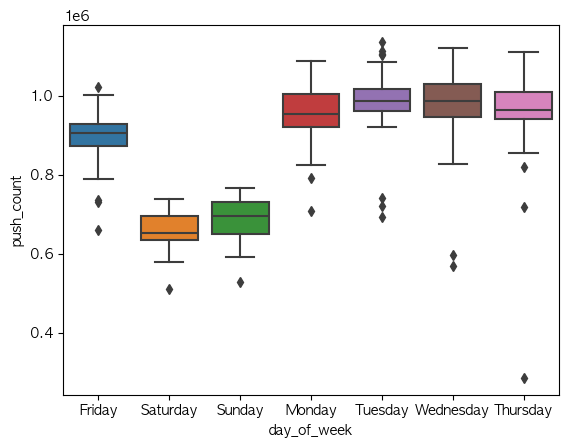

In [14]:
sns.boxplot(data=df, x='day_of_week', y='push_count')
plt.show()

#### push_count에 대한 요일별  히스토그램

- matplotlib을 이용하여 요일별 히스토그램을 한 윈도우에 겹쳐서 그리기

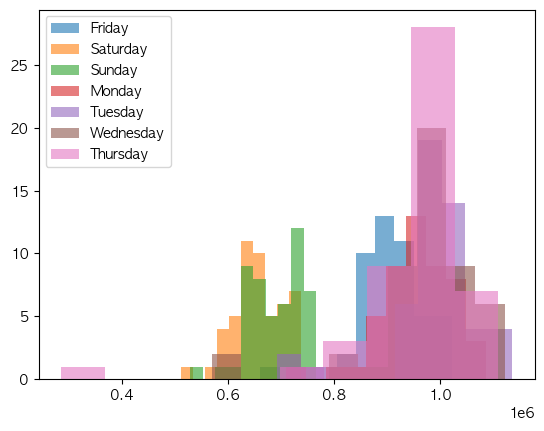

In [15]:
for day in df['day_of_week'].unique():
    plt.hist(df[df['day_of_week']==day]['push_count'], alpha=0.6, label=day)
    plt.legend()

- seaborn을 이용하여 요일별 히스토그램 그리기

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='push_count', ylabel='Count'>

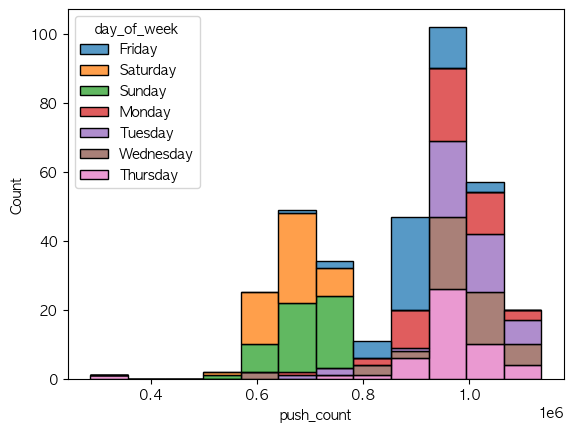

In [16]:
sns.histplot(data=df, x='push_count', hue='day_of_week', multiple='stack')

### 이상치 탐색 및 제거

In [17]:
# 이상치 제거 함수화
def remove_outliers(x):
    q1 = x['push_count'].quantile(0.25)
    q3 = x['push_count'].quantile(0.75)
    IQR = q3 - q1
    lower = q1 - 1.5 * IQR
    upper = q3 + 1.5 * IQR
    return x[(x['push_count'] >= lower) & (x['push_count'] <= upper)]

In [18]:
ol_df = pd.DataFrame()
for day in df['day_of_week'].unique():
    ro = remove_outliers(df[df['day_of_week'] == day])
    df1 = pd.DataFrame(ro[['push_count', 'day_of_week']])
    ol_df = pd.concat([ol_df, df1])
ol_df

,push_count,day_of_week
7,876558,Friday
14,848699,Friday
21,917177,Friday
28,877648,Friday
35,871289,Friday
...,...,...
307,1109582,Thursday
314,1061678,Thursday
321,999443,Thursday
335,854673,Thursday


#### 이상치 제거 후 push_count의 요일별 박스플롯

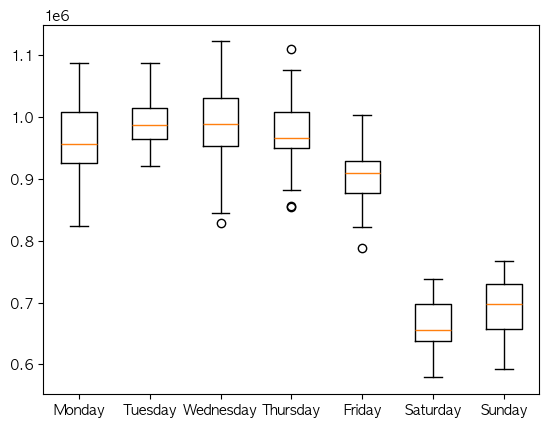

In [21]:
days = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']
plt.boxplot([ol_df[ol_df['day_of_week'] == day].push_count for day in days])
plt.xticks([1,2,3,4,5,6,7], days)
plt.show()

## 일원분산분석

### 1. 가설 설정

### 2. 정규성 검정

- 원 데이터로 요일별 push_count의 정규성 검정

In [25]:
df[df['day_of_week']=='Monday'].push_count

3       709256
10      933373
17      895603
24      975518
31      953642
38      958071
45      973138
52      985210
59      942929
66     1019979
73      960241
80      869363
87      950336
94      945787
101     944651
108     937562
115     863598
122     941040
129     921310
136     918547
143     914440
150     881688
157     915404
164     925569
171     922097
178     969388
185     954540
192     918449
199     980444
206     929137
213     893356
220     975349
227     997987
234    1012245
241     994475
248     981909
255    1007130
262    1035013
269    1013830
276    1009602
283    1026837
290    1037372
297    1072204
304    1087212
311    1084186
318    1029784
325     823771
332     792344
339     945107
346    1034195
Name: push_count, dtype: int64

In [32]:
days = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']
for day in days:
    print(f"{day} : {stats.shapiro(df[df['day_of_week'] == day].push_count)}")

Monday : ShapiroResult(statistic=0.9503622651100159, pvalue=0.035305023193359375)
Tuesday : ShapiroResult(statistic=0.8026376962661743, pvalue=1.0089271427204949e-06)
Wednesday : ShapiroResult(statistic=0.7955164909362793, pvalue=8.438798886345467e-07)
Thursday : ShapiroResult(statistic=0.6433734893798828, pvalue=1.169132346490187e-09)
Friday : ShapiroResult(statistic=0.9204055666923523, pvalue=0.0024389210157096386)
Saturday : ShapiroResult(statistic=0.9624285101890564, pvalue=0.11236860603094101)
Sunday : ShapiroResult(statistic=0.9517911672592163, pvalue=0.040432821959257126)


- 이상치 제거한 데이터로 요일별 push_count의 정규성 검정

In [33]:
days = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']
for day in days:
    print(f"{day} : {stats.shapiro(ol_df[ol_df['day_of_week'] == day].push_count)}")

Monday : ShapiroResult(statistic=0.988259494304657, pvalue=0.9085444211959839)
Tuesday : ShapiroResult(statistic=0.953101634979248, pvalue=0.07741111516952515)
Wednesday : ShapiroResult(statistic=0.9800050854682922, pvalue=0.5924699902534485)
Thursday : ShapiroResult(statistic=0.9782474637031555, pvalue=0.5360512733459473)
Friday : ShapiroResult(statistic=0.9857091307640076, pvalue=0.8369552493095398)
Saturday : ShapiroResult(statistic=0.9630800485610962, pvalue=0.12683847546577454)
Sunday : ShapiroResult(statistic=0.9575086832046509, pvalue=0.07481449097394943)


- p-value < 0.05 (유의 수준): 귀무가설 기각. 즉, 데이터가 정규 분포를 따르지 않는다.
- p-value ≥ 0.05 : 귀무가설 기각하지 않음. 즉, 데이터가 정규 분포를 따른다.

=> 위 경우엔 정규분포를 따름

### 3. 등분산성 검정

In [44]:
stats.levene(*[ol_df[ol_df['day_of_week'] == day]['push_count'] for day in days])

# Ensure there are at least two groups before calling stats.levene
# if len(list1) < 2:
#     raise ValueError("Must enter at least two input sample vectors.")

LeveneResult(statistic=2.1706182771306146, pvalue=0.04555511566154481)

- p-value < 0.05 (유의 수준): 귀무가설 기각. 즉, 그룹 간 분산이 동일하지 않다다.
- p-value ≥ 0.05: 귀무가설 기각하지 않음. 즉, 그룹 간 분산이 동일하다.

=> p-value < 0.05이므로 귀무가설을 기각함 / 즉 이분산을 보임.

### 4. 분산분석 수행
- 가정 검정 결과에 맞게 분석을 수행하시오.

In [46]:
welch_anova(dv='push_count', between='day_of_week', data=df)

,Source,ddof1,ddof2,F,p-unc,np2
0,day_of_week,6,149.7967,246.894436,5.168652e-75,0.722468


=> 'p-value'가 0.05보다 작으므로 귀무가설 기각. 통계적으로 유의미. 요일별 푸시 횟수 다름.

### 5. 사후검정 수행

- 어느 요일간에 차이가 있는가?

In [49]:
# Bonferroni test
comp = MultiComparison(df.push_count, df.day_of_week)
result = comp.allpairtest(stats.ttest_ind, method='bonf')
result[0]

group1,group2,stat,pval,pval_corr,reject
Friday,Monday,-4.1317,0.0001,0.0016,True
Friday,Saturday,20.5473,0.0,0.0,True
Friday,Sunday,17.3043,0.0,0.0,True
Friday,Thursday,-2.8226,0.0058,0.1214,False
Friday,Tuesday,-5.858,0.0,0.0,True
Friday,Wednesday,-4.1979,0.0001,0.0013,True
Monday,Saturday,24.8442,0.0,0.0,True
Monday,Sunday,21.5632,0.0,0.0,True
Monday,Thursday,0.1348,0.893,1.0,False
Monday,Tuesday,-2.0719,0.0409,0.859,False


In [50]:
# Tukey's HSD test
hsd = pairwise_tukeyhsd(df.push_count, df.day_of_week)
hsd.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Friday,Monday,57456.92,0.0079,9471.29,105442.55,True
Friday,Saturday,-239963.34,0.0,-287948.97,-191977.71,True
Friday,Sunday,-208572.4,0.0,-256558.03,-160586.77,True
Friday,Thursday,54814.0702,0.0145,6584.237,103043.9035,True
Friday,Tuesday,89619.18,0.0,41633.55,137604.81,True
Friday,Wednesday,73245.009,0.0002,25015.1757,121474.8422,True
Monday,Saturday,-297420.26,0.0,-345405.89,-249434.63,True
Monday,Sunday,-266029.32,0.0,-314014.95,-218043.69,True
Monday,Thursday,-2642.8498,1.0,-50872.683,45586.9835,False
Monday,Tuesday,32162.26,0.4242,-15823.37,80147.89,False


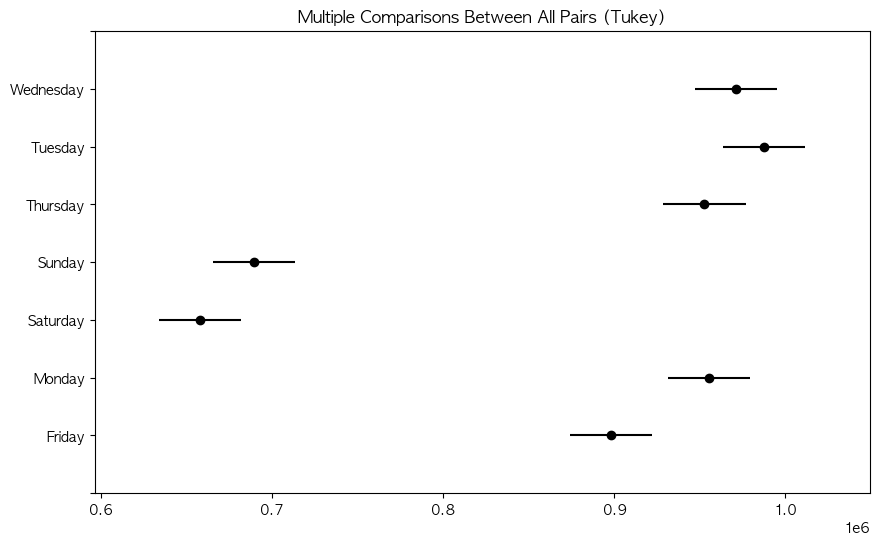

In [51]:
fig = hsd.plot_simultaneous()

----------------------------------